# A TUTORIAL ON HAMINTONIAN MONTE CARLO

by Sebastian T. Glavind, January, 2022


In [1]:
import jax # automatic differentiation
import jax.numpy as jnp
import jax.scipy.stats as jss

import numpy as np
import scipy
import scipy.stats as ss

from tqdm import tqdm # progress bars
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
print('numpy: ', np.__version__,', scipy: ', scipy.__version__, ', jax: ', jax.__version__)

numpy:  1.21.2 , scipy:  1.7.3 , jax:  0.2.26


# Hamintonian Monte Carlo

## Introduction

Hamiltonian Monte Carlo (HMC) is an effifient algorithm for performing Markov chain Monte Carlo (MCMC) inference, which uses gradients of the log-posterior distribution to guide the generation of new proposal states - the gradient at a given state provides information on the geometry of the posterior density function. Based on the gradient information, HMC can propose new states far from the current state with high acceptance probability by solving the so-called Hamiltonian equations, and it can thereby avoid the typical MCMC (local) random walk behaiviour. This enables HMC to scale to higher dimensions.

The basis for HMC is to consider the sampling domain as a conservative dynamical system, where the total energy - in terms of kinetic energy (momentum) and potential energy (position) - is preserved, i.e., if the system gains kinetic energy then is loses the same amount of potential energy. In a physical setting, the potential energy is due to the pull of gravity, and the momentum is due to the motion of the particle. As an example, consider a particle with zero momentum on a declining surface; it will be pulled downwards by gravity, and its potential energy (from its initial height) will be transferred into kinetic energy (motion). Conversely, if the particle is moving along a flat plain, and it encounters a rise, it will slow down as it ascends, transferring its kinetic energy into potential energy.

We thus consider the so-called momentum-position phase space, which can be represended by the following, convenient joint probability distribution:

$$p(\mathbf{p}, \mathbf{q}) = p(\mathbf{p} | \mathbf{q}) p(\mathbf{q}).$$

In this representation, we can immediately recover the target distribution for the position (parameters) $p(\mathbf{q})$ by marginalizing out the momentum $\mathbf{p}$, and thus $\mathbf{p}$ is regarded as an auxilary variable. 

The joint distribution, also called the canonical density, for such a system may also be represented in terms of the invariant Hamiltonian function:  

$$ p(\mathbf{p}, \mathbf{q}) = \exp( -H(\mathbf{p}, \mathbf{q}) ), $$

where the value of the Hamiltonian function at any point in phase space represents the total energy at that point. Thus, as the joint density decomposes, the Hamiltonian function may be written:

$$ H(\mathbf{p}, \mathbf{q}) = - \log p(\mathbf{p}, \mathbf{q}) = \underbrace{- \log p(\mathbf{p} | \mathbf{q})}_{K(\mathbf{p}, \mathbf{q})} \underbrace{- \log p(\mathbf{q})}_{V(\mathbf{q})}  =  K(\mathbf{p}, \mathbf{q}) + V(\mathbf{q}), $$

where $K(\mathbf{p}, \mathbf{q})$ resembles the kinetic energy and $V(\mathbf{q})$ resembles the potential energy.

The trajectory of a particle within an energy level set can be obtained (simulated) by solving the following continuous time differential equations, known as Hamilton’s equations;

$$ 
\require{xcancel}
\begin{align}
\frac{d\mathbf{q}}{dt} &= \frac{ \partial H }{\partial \mathbf{p}} = \frac{ \partial K }{\partial \mathbf{p}} + \xcancel{ \frac{ \partial V }{\partial \mathbf{p}} } \\
\frac{d\mathbf{p}}{dt} &= - \frac{ \partial H }{\partial \mathbf{q}} = - \frac{ \partial K }{\partial \mathbf{q}} - \frac{ \partial V }{\partial \mathbf{q}},
\end{align}
$$

where $\partial V / \partial \mathbf{p}$ cancels, as $V$ does not depend on $\mathbf{p}$. This mapping is volume preserving, i.e., it has a Jacobian determinant of 1, a facts that will is important when turning then system into an MCMC algorithm.

If we now chose the kinetic energy to be a Gaussian and drop the normalization constant, we have:

$$
K(\mathbf{p}, \mathbf{q}) = \frac{1}{2} \mathbf{p}^T M^{-1} \mathbf{p} + \log |M|,
$$

where M is called the mass matrix in the HMC literature. We scose this to be the identity matrix, i.e., $M=I$, which leads to

$$
K(\mathbf{p}, \mathbf{q}) = \frac{1}{2} \mathbf{p}^T \mathbf{p},
$$

which simplifies the Hamiltonian equations to

$$ 
\begin{align}
\frac{d\mathbf{q}}{dt} &= \mathbf{p} \\
\frac{d\mathbf{p}}{dt} &= - \frac{ \partial V }{\partial \mathbf{q}},
\end{align}
$$

as $\partial K / \partial \mathbf{p}=\mathbf{p}$ and $\partial K / \partial \mathbf{q}=0$ for the Gaussian definition of $K(\mathbf{p}, \mathbf{q})$ above; see e.g., Hoffman and Gelman (2014), Betancourt (2017), Martin et al (2021) and Murphy (2023) for further details.

A simulation procedure is now taken shape; thus, we can sample $\mathbf{p}_0 \sim \mathcal{N}(0,I)$ and simulate a trajectory $\{ \mathbf{q}_t, \mathbf{p}_t \}_{t=1}^T$ for some amount of time $T$, where $\mathbf{q}_T$ is then our new sample. In the following section, we will study how we simulate the trajectory $\{ \mathbf{q}_t, \mathbf{p}_t \}_{t=1}^T$ by solving Hamilton’s equations.

***
Hoffman, Matthew D., and Andrew Gelman. "The No-U-Turn sampler: adaptively setting path lengths in Hamiltonian Monte Carlo." J. Mach. Learn. Res. 15.1 (2014): 1593-1623 ([link](https://www.jmlr.org/papers/volume15/hoffman14a/hoffman14a.pdf)).

Betancourt, Michael. "A conceptual introduction to Hamiltonian Monte Carlo." arXiv preprint arXiv:1701.02434, 2017 ([link](https://arxiv.org/pdf/1701.02434.pdf?ref=https://githubhelp.com))

Martin, Osvaldo A. and Kumar, Ravin and Lao, Junpeng, "Bayesian Modeling and Computation in Python", CRC, 2021.

Murphy, Kevin P., "Probabilistic Machine Learning: Advanced Topics", MIT Press, 2023 ([draft](https://probml.github.io/pml-book/book2.html) from feb. 2022).
***

## Solving Hamilton's equations

In this section, we discuss how to simulate trajectories from Hamilton’s equations in discrete time.

### Euler's method

One simple way to simulate these trajectories is to update the position and momentum simultaneously by a small amount based on the gradients:

$$ 
\begin{align}
\mathbf{p}_{t+1} &= \mathbf{p}_{t} + \eta \frac{d\mathbf{p}}{dt}(\mathbf{q}_t,\mathbf{p}_t) = \mathbf{p}_{t} - \eta \frac{ \partial V }{\partial \mathbf{q}}(\mathbf{q}_t) \\
\mathbf{q}_{t+1} &= \mathbf{q}_{t} + \eta \frac{d\mathbf{q}}{dt}(\mathbf{q}_t,\mathbf{p}_t) = \mathbf{q}_{t} + \eta \mathbf{p}_{t},
\end{align}
$$

where $\eta$ is the step size, and we have included the simple definition for kinetic energy above in the second expression. Unfortunally, though, Euler’s method does not preserve volume, and can lead to inaccurate approximations after only a few steps. 

### Modified Euler's method

In Modified Euler's method, we make Euler's method symplectic (volume preserving) by first updating the momentum, and then we update the position using the new momentum:

$$ 
\begin{align}
\mathbf{p}_{t+1} &= \mathbf{p}_{t} + \eta \frac{d\mathbf{p}}{dt}(\mathbf{q}_t,\mathbf{p}_t) = \mathbf{p}_{t} - \eta \frac{ \partial V }{\partial \mathbf{q}}(\mathbf{q}_t) \\
\mathbf{q}_{t+1} &= \mathbf{q}_{t} + \eta \frac{d\mathbf{q}}{dt}(\mathbf{q}_t,\mathbf{p}_{t+1}) = \mathbf{q}_{t} + \eta \mathbf{p}_{t+1},
\end{align}
$$

Note that we can equivalently perform the updates in the opposite order. Unfortunally, this procedure is not reversible due to the asymmetry in the updates.

### Leapfrog integrator

Using the Leapfrog integrator, we can make Euler's method symplectic and reversible by first performing a half-update of the momentum, next we perform a full update of the position, and then we perform another
half-update of the momentum:

$$ 
\begin{align}
\mathbf{p}_{t+1/2} &= \mathbf{p}_{t} + \frac{\eta}{2} \frac{d\mathbf{p}}{dt}(\mathbf{q}_t,\mathbf{p}_t) = \mathbf{p}_{t} - \frac{\eta}{2} \frac{ \partial V }{\partial \mathbf{q}}(\mathbf{q}_t) \\
\mathbf{q}_{t+1} &= \mathbf{q}_{t} + \eta \frac{d\mathbf{q}}{dt}(\mathbf{q}_t,\mathbf{p}_{t+1/2}) = \mathbf{q}_{t} + \eta \mathbf{p}_{t+1/2} \\
\mathbf{p}_{t+1} &= \mathbf{p}_{t+1/2} + \frac{\eta}{2} \frac{d\mathbf{p}}{dt}(\mathbf{q}_{t+1},\mathbf{p}_{t+1/2}) = \mathbf{p}_{t+1/2} - \frac{\eta}{2} \frac{ \partial V }{\partial \mathbf{q}}(\mathbf{q}_{t+1}),
\end{align}
$$

It can be shown that the Leapfrog integrator is volumen preserving, and given that we reverse the momentum at the end of the iteration, i.e., replace $\mathbf{p}$ by $-\mathbf{p}$, it is also reversible. Note that if the kinetic energy satisfies $K(\mathbf{p})=K(-\mathbf{p})$, the reversal of momentum is not needed to make the method reversible. 

How effectively HMC explores the target distribution is determined by the integration length $T$, or equavantly the number of leapfrog steps $L$, at each iteration. One the one hand, if we integrate for only a short time then we do not take full advantage of the coherent exploration of the Hamiltonian trajectories, and the algorithm will exhibit random walk-like behaviour. On the other hand, trajectories will eventually return to previously explored neighborhoods, i.e., integrating too long can suffer from diminishing returns.

Unfortunally, the Leapfrog integrator does not exactly perserve energy, due to the finite step size. This, however, can be fixed by treating the method as a proposal distribution, and then we can use the Metropolis acceptance criterion to ensure that we sample form the target distribution. The Metropolis acceptance criterion for this case is defined as

$$
\mathbf{q}_{k+1} = 
\begin{cases}
  \mathbf{q}_{T} & \text{with probability}\ \min\left( \left[p(\mathbf{q}_{T}, \mathbf{p}_{T}) \big/ p(\mathbf{q}_{k}, \mathbf{p}_0) \right], \ 1 \right) \\
  \mathbf{q}_{k} & \text{otherwise},
\end{cases}
$$

where $(\mathbf{q}_{T}, \mathbf{p}_{T})$ is our porposal, and $(\mathbf{q}_{k}, \mathbf{p}_{0})$ is the previous sample of $\mathbf{q}$ and the random, initial momentum for sample $k+1$, respectively. For more information on solving Hamilton's equations, see Murphy (2023), as well as this nice [blog post](https://bayesianbrad.github.io/posts/2019_hmc.html).

In [3]:
# Code inspired by the implementation in the "Bayesian Modeling and Computation in Python" book
# https://bayesiancomputationbook.com/markdown/chp_11.html

def leapfrog(q, p, dVdq, path_len, step_size):
    p -= step_size * dVdq(q) / 2  # half step
    for _ in range(int(path_len / step_size) - 1):
        q += step_size * p  # whole step
        p -= step_size * dVdq(q)  # whole step
    q += step_size * p  # whole step
    p -= step_size * dVdq(q) / 2  # half step

    return q, -p  # momentum flip at end

## The HMC algorithm

Now that we have the boilding blocks, we are ready to summarize the HMC algorithm:

At each iteration, we

1. sample a momentum $\mathbf{p}_0 \sim \mathcal{N}(0,I)$ and 

2. simulate a trajectory $\{ \mathbf{q}_t, \mathbf{p}_t \}_{t=1}^T$ for some amount of time $T$, i.e., $L$ Leapfrog steps.

3. chose $\mathbf{q}_T$ is then our new sample.

4. use the Metropolis acceptance criterion to judge whether $\mathbf{q}_T$ should be accepted or rejected as a sample from the traget distribution.


Note that in order the make the HMC implementation below general, we will use the autodiff library `jax`, whereby the implementation does not rely on our ability to provide the analytical gradients for the Leapfrog integrator.  

In [4]:
def hamiltonian_monte_carlo(
    n_samples, negative_log_prob, initial_position, path_len=1, step_size=0.5):
    # counter of acceptance
    counter = 0
    # jax autodiff magic - initialize
    dVdq = jax.grad(negative_log_prob)
    # collect all our samples in a list
    samples = [initial_position]
    # Keep a single object for momentum resampling
    momentum = ss.norm(0, 1)
    # If initial_position is a 10d vector and n_samples is 100, we want
    # 100 x 10 momentum draws. We can do this in one call to momentum.rvs, and
    # iterate over rows
    size = (n_samples,) + initial_position.shape[:1]
    for p0 in momentum.rvs(size=size):
        # Integrate over our path to get a new position and momentum
        q_new, p_new = leapfrog(
            samples[-1], p0, dVdq, path_len=path_len, step_size=step_size)
        # Check Metropolis acceptance criterion
        start_log_p = negative_log_prob(samples[-1]) - np.sum(momentum.logpdf(p0))
        new_log_p = negative_log_prob(q_new) - np.sum(momentum.logpdf(p_new))
        if np.log(np.random.rand()) < start_log_p - new_log_p:
            samples.append(q_new)
            counter += 1
        else:
            samples.append(np.copy(samples[-1]))

    return np.array(samples[1:]), counter

## Setting the step size by dual avaging

To set the step size $\epsilon$ in HMC (and its extension the no-uturn sampler (NUTS)), Hoffman and Gelman (2014) propose to use stochastic optimization with vanishing adaptation, specifically an extension of the primal-dual algorithm of Nesterov (2009).

Generally, we consider a statistic $H_k$ that describes some aspect of the behavior of an MCMC algorithm at iteration $k$, which has expectation $h(x)$, where $x \in \mathbb{R}$ is a tunable parameter of the MCMC algorithm. For our case, we will target the average Metropolis acceptance probability (see above) based on the criterion 

$$
H_k = \delta - \alpha_k; \quad h(x) = \mathbb{E}[H_k|x]
$$

where $\delta$ is the desired average acceptance probability, and $\alpha_k$ is the Metropolis acceptance probability for iteration $k$. The following updating scheme: 

$$
x_{k+1} = \mu - \frac{\sqrt(k)}{\gamma} \frac{1}{k + k_0} \sum_{i=1}^k H_i; \quad \bar{x}_{k+1} \leftarrow \eta_k x_{k+1} + (1 - \eta_k) \bar{x}_k
$$

than guarantees that the sequence of averaged iterates $\bar{x}_k$ converges to a value, such that $h(\bar{x}_k)$ converges to $0$ for $\eta_k = k^{-\kappa}$ with $\kappa \in (0.5, 1]$. Further, $\mu$ is a freely chosen point that the iterates $x_k$ are shrunk towards, $\gamma > 0$ is a free parameter that controls the amount of shrinkage towards $\mu$, $k_0 \geq 0$ is a free parameter that stabilizes the initial iterations of the algorithm, and we define $\bar{x}_1 = x_1$. 

Hoffman and Gelman (2014) propose to use $x = \log \epsilon$ with parameters $\gamma = 0.05$, $t_0 = 10$, $\kappa = 0.75$, and $\mu = \log(10 \epsilon_0)$, where $\epsilon_0$ is the initial step size. Moreover, it has been shown that the optimal value of $\epsilon$ for a given simulation length $\epsilon L$ is the one that produces an average Metropolis acceptance probability of approximately $0.65$, thus we set $\delta=0.65$. Please refer to Hoffman and Gelman (2014) for further details.

***
Hoffman, Matthew D., and Andrew Gelman. "The No-U-Turn sampler: adaptively setting path lengths in Hamiltonian Monte Carlo." J. Mach. Learn. Res. 15.1 (2014): 1593-1623 ([link](https://www.jmlr.org/papers/volume15/hoffman14a/hoffman14a.pdf)).

Nesterov, Yurii. "Primal-dual subgradient methods for convex problems." Mathematical programming 120.1 (2009): 221-259.
***

In [5]:
# See Hoffman and Gelman (2013), section 3.2.1.
# https://colindcarroll.com/2019/04/21/step-size-adaptation-in-hamiltonian-monte-carlo/
# https://github.com/ColCarroll/minimc/blob/master/minimc/minimc.py

class DualAveragingStepSize:
    def __init__(self, initial_step_size, target_accept=0.65, gamma=0.05, t0=10.0, kappa=0.75):
        self.mu = np.log(10 * initial_step_size)  # proposals are biased upwards to stay away from 0.
        self.target_accept = target_accept
        self.gamma = gamma
        self.t = t0
        self.kappa = kappa
        self.error_sum = 0
        self.log_averaged_step = 0

    def update(self, p_accept):
        # Running tally of absolute error. Can be positive or negative, but optimally 0.
        self.error_sum += self.target_accept - p_accept
        # This is the next proposed (log) step size. Note it is biased towards mu.
        log_step = self.mu - self.error_sum / (np.sqrt(self.t) * self.gamma)
        # Forgetting rate. As 't' gets bigger, 'eta' gets smaller.
        eta = self.t ** -self.kappa
        # Smoothed average step size
        self.log_averaged_step = eta * log_step + (1 - eta) * self.log_averaged_step
        # State update, such taht 't' keeps updating
        self.t += 1
        # Return both the noisy step size (tuning phase), and the smoothed step size (after tuning)
        return np.exp(log_step), np.exp(self.log_averaged_step)    

def hamiltonian_monte_carlo_dual(
    n_samples, negative_log_prob, initial_position, path_len=1, initial_step_size=0.5, tune=500):
    # counter of acceptance
    counter = 0
    # jax autodiff magic - initialize
    dVdq = jax.grad(negative_log_prob)
    # collect all our samples in a list
    samples = [initial_position]
    # Keep a single object for momentum resampling
    momentum = ss.norm(0, 1)
    # Step size adaption - initialization
    step_size = initial_step_size
    step_size_tuning = DualAveragingStepSize(step_size)
    # If initial_position is a 10d vector and n_samples is 100, we want
    # 100 x 10 momentum draws. We can do this in one call to momentum.rvs, and
    # iterate over rows
    size = (n_samples + tune,) + initial_position.shape[:1]
    for idx, p0 in tqdm(enumerate(momentum.rvs(size=size)), total=size[0]):
    # for idx, p0 in enumerate(momentum.rvs(size=size)):      
        # Integrate over our path to get a new position and momentum
        # NB!!! Jitter the path length to stabilize algorithm - on average it equals the specified path length
        q_new, p_new = leapfrog(
            samples[-1], p0, dVdq, path_len=2*np.random.rand()*path_len, step_size=step_size)
        # Check Metropolis acceptance criterion
        start_log_p = np.sum(momentum.logpdf(p0)) - negative_log_prob(samples[-1])
        new_log_p = np.sum(momentum.logpdf(p_new)) - negative_log_prob(q_new)
        p_accept = min(1, np.exp(new_log_p - start_log_p))       
        if np.random.rand() < p_accept:
            samples.append(q_new)
            if idx > tune - 1:
                counter += 1
        else:
            samples.append(samples[-1])
        # Step size adaption
        if idx < tune - 1:
            step_size, _ = step_size_tuning.update(p_accept)
        elif idx == tune - 1:
            _, step_size = step_size_tuning.update(p_accept)

    return np.array(samples[1 + tune :]), counter, step_size

# Numerical example

In this tutorial, we will study how HMC can be used to perform Bayesian inference in linear regression. For this simple case, we can ofcause derive the analytical gradients needed by the Leapfrog integrator, see e.g., my tutorial on linear regression ([link](https://nbviewer.org/github/SebastianGlavind/PhD-study/blob/master/Linear-regression/LinReg.ipynb)), but to showcase the generality of the implementation above, we will used the autodiff library `jax` for this case as well.   

## The model

In the simplest case of linear regression, sometimes called ordinary linear regression, the scalar output $y$ is assumed to be a linear combination of the inputs $\mathbf{x}$, and the observation errors follow a Gaussian white noise distribution, thus

$$ y | \mathbf{w}, \sigma, \mathbf{x} \sim \mathcal{N}(w_0 + \sum_{m=1}^{M-1} w_m x_m, \sigma^2) = \mathcal{N}(\mathbf{w}^T \mathbf{x}, \sigma^2), $$

where we have augmented the input vector $\mathbf{x}$ with an additional first element, which is always 1, i.e, $\mathbf{x} = (1, x_1, x_2, ..., x_{M-1})$, and the corresponding weight vector $\mathbf{w} = (w_0, w_1, w_2, ..., w_{M-1})$.

If we now consider a training data set $\mathcal{D}=\{ \mathbf{x}[n], y[n] \}_{n=1}^N = \{ \mathbf{X}, \mathbf{y} \}$, where $\mathbf{X}$ is a $ N \times M $ design matrix and $\mathbf{y}$ is a column vector of the corresponding output observations, the joint likelihood of the training data may be written:

$$ \mathbf{y} | \mathbf{w}, \sigma, \mathbf{X} \sim \prod_{n=1}^N \mathcal{N}(\mathbf{w}^T \mathbf{x}[n], \sigma^2) = \mathcal{N}(\mathbf{X}\mathbf{w},\sigma^2\mathbf{I}), $$

where $\mathbf{I}$ is an $ N \times N $ identity matrix.

## Sample data

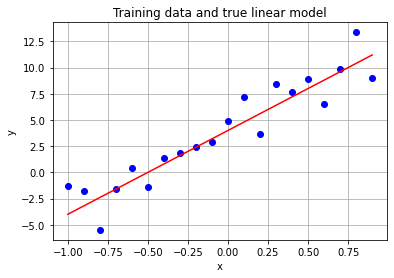

In [6]:
# True, underlaying model
w0_true = 4
w1_true = 8
sigma_true = 2

def generate_training_data(x, w0, w1, sigma):
    n = len(x)
    error = np.random.normal(loc=0, scale=sigma, size=n)
    return( w0 + w1*x + error )

# Generate and plot data
x_tr = np.arange(start=-1, stop=1, step=0.1)
np.random.seed(10) # good seed
y_tr = generate_training_data(x=x_tr, w0 = w0_true, w1 = w1_true, sigma = sigma_true)

XX = np.vstack((np.ones(len(x_tr)), x_tr)).T # design matrix (convention Bishop(2006))
nX_tr, mX_tr = XX.shape # - np.array([0, 1]); # data dimensions are defined as actual features ;)

x_te = np.arange(start=-1.25, stop=1.25, step=0.1)
XX_te = np.vstack((np.ones(len(x_te)), x_te)).T # design matrix (convention Bishop(2006))
nX_te, mX_te = XX_te.shape # - np.array([0, 1]); # data dimensions are defined as actual features ;)

plt.plot(x_tr, y_tr,'ob');
plt.plot(x_tr,(w0_true + w1_true * x_tr),'-r');
plt.xlabel('x')
plt.ylabel('y')
plt.title('Training data and true linear model')
plt.grid()

## Bayesian inference

See e.g. Gelman et al. (2013; Sec.12.4 and App.C.4 (R implementation)) for a reference on the Hamiltonian Monte Carlo algorithm.

### The generative story

We sample a realization of the parameter vector $\theta$ as

$$ p(\boldsymbol\theta |\mathcal{D}) \propto p(\mathbf{y}|\mathbf{X},\boldsymbol\theta) p(\boldsymbol\theta), $$

where $$ \theta_{0:1} = w_{0:1} \sim \mathcal{N}(0,10), $$

and $$ \theta_{2} = \sigma^2 \sim \text{Gamma}(2,2). $$

### The unnormalized parameter posterior

Recall that the parameter posterior is defined through Bayes' rule as 

$$p(\boldsymbol\theta|\mathcal{D}) = \frac{ p(\mathbf{y},\boldsymbol\theta|\mathbf{x}) }{ p(\mathbf{y})}, $$

but we will work with the unnormalized version, i.e.

$$p(\boldsymbol\theta|\mathcal{D}) \propto p(\mathbf{y},\boldsymbol\theta|\mathbf{x}), $$

to avoid calculating the always troubling normalizing constant $\mathbf{y}$.

***
Gelman, Andrew, et al. Bayesian data analysis. CRC press, 2013.
***

In [7]:
# This function calculates the unnormalized posterior for theta, i.e. p(theta|D) = p(y,theta|x)/p(y)
def neg_log_pos_hmc(theta,pam1=np.array([0.,10.]),pam2=np.array([0.,10.]),pam3=np.array([2.,2.])):
    w0 = theta[0]
    w1 = theta[1]
    sig2 = theta[2]
    mu = w0 + w1 * x_tr
    logPos = (sum( jss.norm.logpdf(y_tr, loc = mu, scale = jnp.sqrt(sig2)) )
              + jss.norm.logpdf(w0, loc=pam1[0], scale=pam1[1])
              + jss.norm.logpdf(w1, loc=pam2[0], scale=pam2[1])
              + jss.gamma.logpdf(sig2, a = pam3[0], scale = pam3[1])    
             ) 
    negLogPos = - logPos
    return(negLogPos)

# Test the implementation
print( neg_log_pos_hmc(np.array([4., 8., 4.])) )
print( jax.grad(neg_log_pos_hmc)(np.array([4., 8., 4.])) )

48.206924
[-1.1471946   0.42492092  0.96945906]


## Basic Hamiltonian Monte Carlo

This shows how to sample from éne chain; in a real application, we would initialize multiple chains overdispersed in the plausible range of the variables and check for mixing.

### Sampling from the posterior

In [8]:
# %%time
# Call the HMC implementation
np.random.seed(42)
n_samp_hmc = int(2e2)
samp_hmc, counter_hmc = hamiltonian_monte_carlo(n_samp_hmc, neg_log_pos_hmc, np.array([4., 8., 2.]), path_len=2, step_size=0.65)
counter_hmc/n_samp_hmc

0.645

### Analyze samples

We regard the first half of the samples as burn-in and plot the posterior samples (blue).

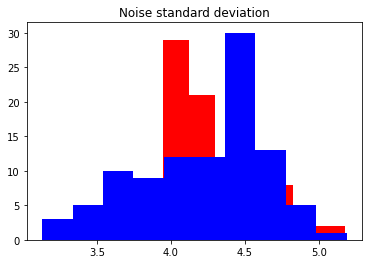

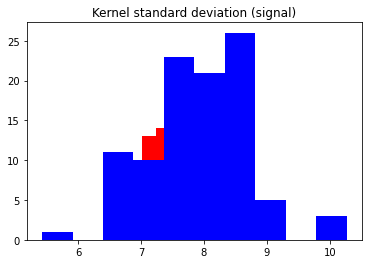

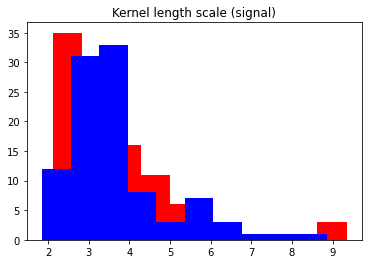

In [9]:
samp_hmc0 = samp_hmc[0:round(n_samp_hmc/2),:] # burn-in
samp_hmc1 = samp_hmc[round(n_samp_hmc/2):n_samp_hmc,:] # without burn-in

# Marginal distribution approximations
plt.figure()
plt.hist(samp_hmc0[:,0], color='red' );
plt.hist(samp_hmc1[:,0] , color='blue' );
plt.title('Noise standard deviation')

plt.figure()
plt.hist(samp_hmc0[:,1], color='red' );
plt.hist(samp_hmc1[:,1] , color='blue' );
plt.title('Kernel standard deviation (signal)')

plt.figure()
plt.hist(samp_hmc0[:,2], color='red' );
plt.hist(samp_hmc1[:,2] , color='blue' );
plt.title('Kernel length scale (signal)');

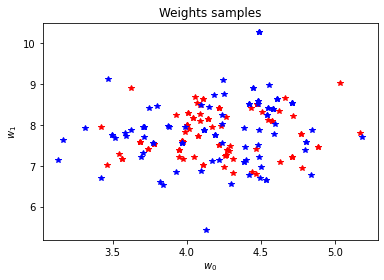

In [10]:
# Scatter plot of regression parameter
plt.plot(samp_hmc0[:,0],samp_hmc0[:,1],'*r');
plt.plot(samp_hmc1[:,0],samp_hmc1[:,1],'*b');
plt.xlabel('$w_0$');
plt.ylabel('$w_1$');
plt.title('Weights samples');

#### Define sample statistics for the latent function (f) and the output (y)

In [11]:
f_pred_hmc = samp_hmc1[:,0:2].dot(XX_te.T)
y_pred_hmc = f_pred_hmc + np.random.normal(scale=np.sqrt(samp_hmc1[:,2])).reshape([-1,1])
mu_pred_hmc = np.mean(f_pred_hmc,axis=0)
cf_pred_f_hmc= np.quantile(f_pred_hmc,q=[0.025, 0.975],axis=0)
cf_pred_y_hmc= np.quantile(y_pred_hmc,q=[0.025, 0.975],axis=0)

#### Plot the resulting model

95\% Bayesian credible interval of the posterior model.

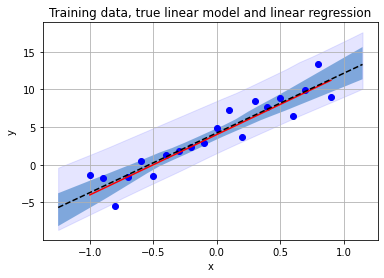

In [12]:
plt.plot(x_tr, y_tr,'ob');
plt.plot(x_tr,(w0_true + w1_true * x_tr),'-r');
plt.plot(x_te,mu_pred_hmc,'--k');
plt.fill_between(x=x_te, y1=cf_pred_f_hmc[0,:], y2=cf_pred_f_hmc[1,:], alpha=0.5);
plt.fill_between(x=x_te, y1=cf_pred_y_hmc[0,:], y2=cf_pred_y_hmc[1,:], alpha=0.1, color='blue');
plt.xlabel('x');
plt.ylabel('y');
plt.title('Training data, true linear model and linear regression');
plt.grid();

## Hamiltonian Monte Carlo with step size adaption

This shows how to sample from éne chain; in a real application, we would initialize multiple chains overdispersed in the plausible range of the variables and check for mixing.

### Sampling from the posterior

In [13]:
# %%time
# Call the HMC implementation
np.random.seed(42)
n_samp_hmc_dual = int(2e2)
samp_hmc_dual, counter_hmc_dual, step_size_hmc_dual = hamiltonian_monte_carlo_dual(n_samp_hmc_dual, neg_log_pos_hmc, np.array([2., 16., 4.]), 
                                                                                   path_len=3, initial_step_size=0.33, tune=100)
print('Acceptance rate: ', counter_hmc_dual/n_samp_hmc_dual)
print('Optimized step size: ', step_size_hmc_dual)

100%|█████████████████████████████████████████| 300/300 [01:53<00:00,  2.65it/s]

Acceptance rate:  0.85
Optimized step size:  5.009077704356696e-01


### Analyze samples

We regard the first half of the samples as burn-in and plot the posterior samples (blue).

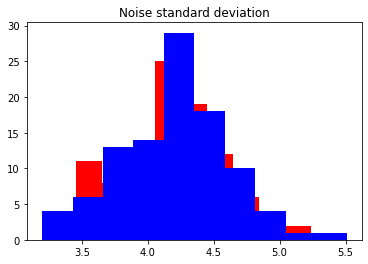

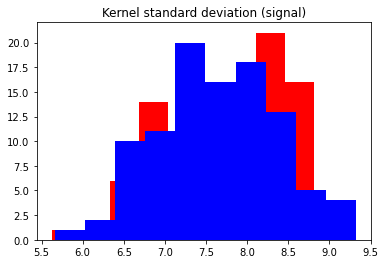

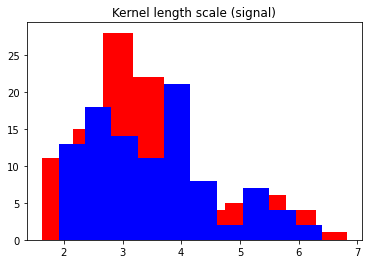

In [14]:
samp_hmc_dual0 = samp_hmc_dual[0:round(n_samp_hmc_dual/2),:] # burn-in
samp_hmc_dual1 = samp_hmc_dual[round(n_samp_hmc_dual/2):n_samp_hmc_dual,:] # without burn-in

# Marginal distribution approximations
plt.figure()
plt.hist(samp_hmc_dual0[:,0], color='red' );
plt.hist(samp_hmc_dual1[:,0] , color='blue' );
plt.title('Noise standard deviation')

plt.figure()
plt.hist(samp_hmc_dual0[:,1], color='red' );
plt.hist(samp_hmc_dual1[:,1] , color='blue' );
plt.title('Kernel standard deviation (signal)')

plt.figure()
plt.hist(samp_hmc_dual0[:,2], color='red' );
plt.hist(samp_hmc_dual1[:,2] , color='blue' );
plt.title('Kernel length scale (signal)');

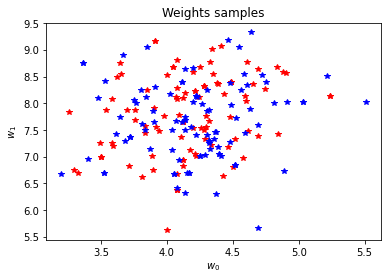

In [15]:
# Scatter plot of regression parameter
plt.plot(samp_hmc_dual0[:,0],samp_hmc_dual0[:,1],'*r');
plt.plot(samp_hmc_dual1[:,0],samp_hmc_dual1[:,1],'*b');
plt.xlabel('$w_0$');
plt.ylabel('$w_1$');
plt.title('Weights samples');

#### Define sample statistics for the latent function (f) and the output (y)

In [16]:
f_pred_hmc_dual = samp_hmc_dual1[:,0:2].dot(XX_te.T)
y_pred_hmc_dual = f_pred_hmc_dual + np.random.normal(scale=np.sqrt(samp_hmc_dual1[:,2])).reshape([-1,1])
mu_pred_hmc_dual = np.mean(f_pred_hmc_dual,axis=0)
cf_pred_f_hmc_dual = np.quantile(f_pred_hmc_dual,q=[0.025, 0.975],axis=0)
cf_pred_y_hmc_dual = np.quantile(y_pred_hmc_dual,q=[0.025, 0.975],axis=0)

#### Plot the resulting model

95\% Bayesian credible interval of the posterior model.

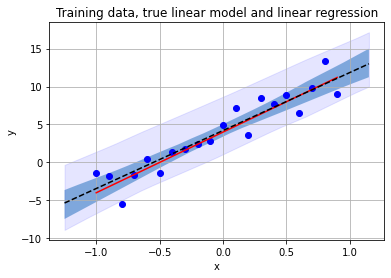

In [17]:
plt.plot(x_tr, y_tr,'ob');
plt.plot(x_tr,(w0_true + w1_true * x_tr),'-r');
plt.plot(x_te,mu_pred_hmc_dual,'--k');
plt.fill_between(x=x_te, y1=cf_pred_f_hmc_dual[0,:], y2=cf_pred_f_hmc_dual[1,:], alpha=0.5);
plt.fill_between(x=x_te, y1=cf_pred_y_hmc_dual[0,:], y2=cf_pred_y_hmc_dual[1,:], alpha=0.1, color='blue');
plt.xlabel('x');
plt.ylabel('y');
plt.title('Training data, true linear model and linear regression');
plt.grid();